In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.manifold import TSNE
from pandas.tools.plotting import andrews_curves
import os
from pandas.tools.plotting import parallel_coordinates
from pandas.tools.plotting import radviz
import scipy

In [86]:
#Modelling
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
#import lightgbm as lgb
import warnings

In [87]:
os.chdir('/home/py/data/AUTO/')

In [166]:
df = pd.read_csv('auto_ex_zero.csv')

In [167]:
df.shape

(998, 12)

In [168]:
del df['Company.Name']
del df['PSALES']
del df['EVEBITDA']
del df['P.E']

In [169]:
df.head(5)

,YEAR,ROE,ROC,NPM,DIV,DEP,Beta,P.B
0,1991,46.00,24.52,20.09,10.34,15.3,0.28,5.94
1,1985,21.10,14.99,6.22,8.48,170.0,0.88,1.66
2,1985,32.04,17.88,6.74,4.23,244.5,0.94,3.30
3,1985,21.00,11.57,4.83,8.49,345.6,0.96,0.78
4,1985,34.97,25.03,9.68,14.83,429.5,1.13,2.57


# Feature Engineering

In [170]:
df["YEAR"] = df["YEAR"].astype("category")

In [171]:
# put ages in categories and add as columns to DataFrame
age_bins = [0, 1960, 1970, 1980, 1990,2000,2017]
age_labels = ["1", "2", "3", "4","5","6"]
df['YEAR'] = pd.cut(df['YEAR'], age_bins, labels=age_labels,right=True, include_lowest=True)

In [172]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

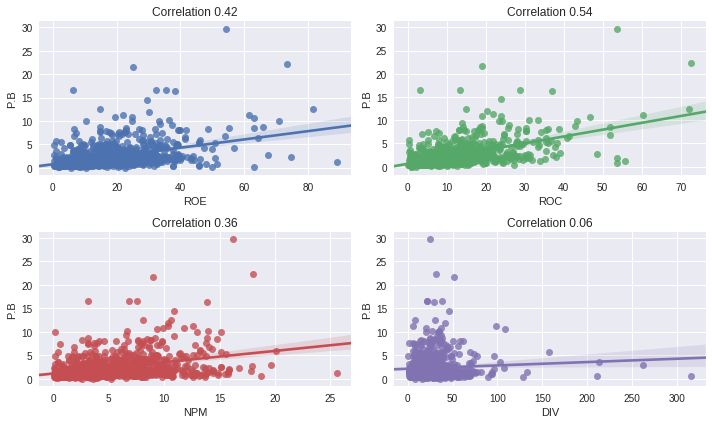

In [173]:
feats = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']

multiplot(data = df,features = feats,plottype = "regplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = 'P.B', colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



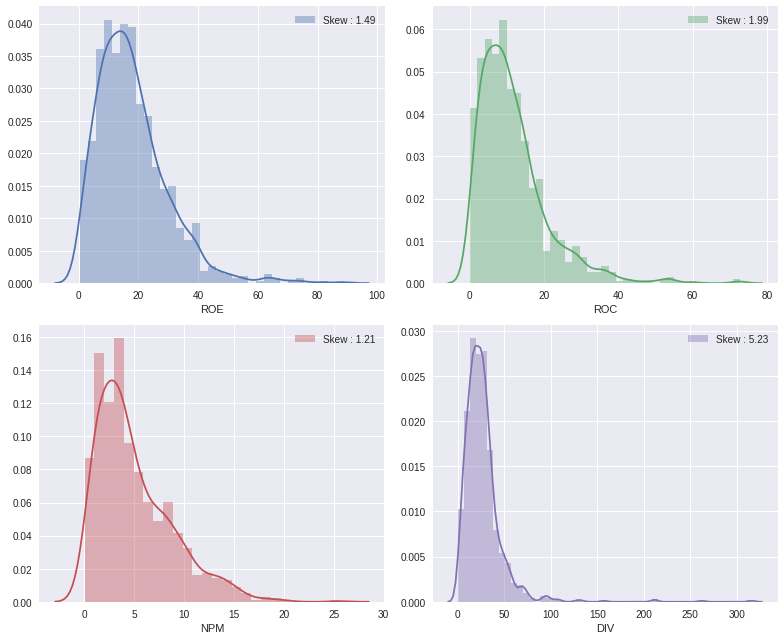

In [174]:
skewed_features = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



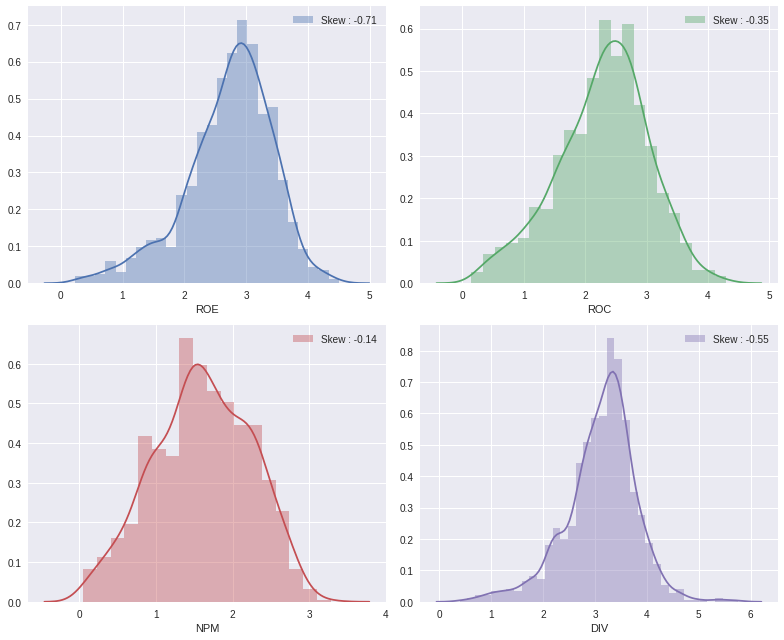

In [175]:
for feature in skewed_features:
    df[feature] = np.log1p(df[feature])
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



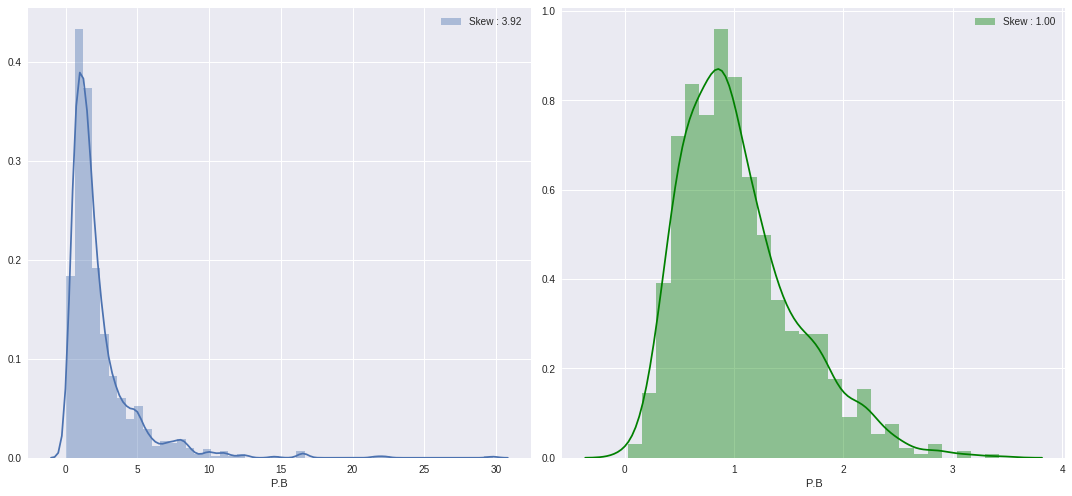

In [176]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(df['P.B'],ax = axes[0])
sns.distplot(np.log1p(df['P.B']),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(df['P.B'].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(df['P.B']).skew())])

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [177]:
df.columns

Index(['YEAR', 'ROE', 'ROC', 'NPM', 'DIV', 'DEP', 'Beta', 'P.B'], dtype='object')

In [178]:
t = df.iloc[:,1:7]

In [179]:
z= df.filter(['YEAR','P.B'], axis=1)

In [180]:
list_ib = t.columns.values

for i in list_ib:
    for j in list_ib:
        if i == j:
            break
        else:
            new = t[i] * t[j]
            t['new_' + str(i) + '_' + str(j)] = new # Add new column which is the result of multiplying columns i and j together

In [181]:
df = pd.concat([t, z], axis = 1)

In [182]:
# Convert year to category
df['Age_1'] = df['YEAR'].map(lambda s: 1 if s == '1' else 0)
df['Age_2'] = df['YEAR'].map(lambda s: 1 if s == '2' else 0)
df['Age_3'] = df['YEAR'].map(lambda s: 1 if s == '3' else 0)
df['Age_4'] = df['YEAR'].map(lambda s: 1 if s == '4' else 0)
df['Age_5'] = df['YEAR'].map(lambda s: 1 if s == '5' else 0)
df['Age_6'] = df['YEAR'].map(lambda s: 1 if s == '6'  else 0)

In [183]:
df.head(5)

,ROE,ROC,NPM,DIV,DEP,Beta,new_ROC_ROE,new_NPM_ROE,new_NPM_ROC,new_DIV_ROE,...,new_Beta_DIV,new_Beta_DEP,YEAR,P.B,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
0,3.850148,3.239462,3.048799,2.428336,2.791165,0.246860,12.472409,11.738326,9.876470,9.349453,...,0.599459,0.689027,5,5.94,0,0,0,0,1,0
1,3.095578,2.771964,1.976855,2.249184,5.141664,0.631272,8.580828,6.119508,5.479770,6.962525,...,1.419847,3.245787,4,1.66,0,0,0,1,0,0
2,3.497719,2.938103,2.046402,1.654411,5.503297,0.662688,10.276659,7.157738,6.012539,5.786666,...,1.096358,3.646969,4,3.30,0,0,0,1,0,0
3,3.091042,2.531313,1.763017,2.250239,5.848171,0.672944,7.824396,5.449560,4.462748,6.955583,...,1.514286,3.935495,4,0.78,0,0,0,1,0,0
4,3.582685,3.259250,2.368373,2.761907,6.064947,0.756122,11.676866,8.485134,7.719118,9.895043,...,2.088338,4.585840,4,2.57,0,0,0,1,0,0


# Explanotary Data Analysis

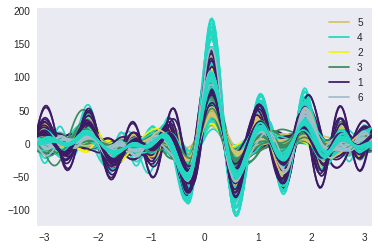

In [184]:
andrews_curves(df, 'YEAR')
plt.show()

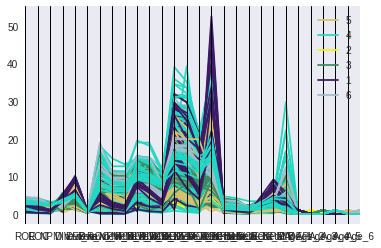

In [185]:
parallel_coordinates(df, 'YEAR')

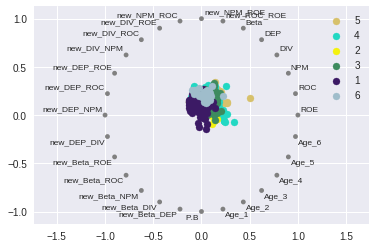

In [186]:
radviz(df, 'YEAR')

In [187]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
)

In [188]:
tsne_results = tsne.fit_transform(df.iloc[:, 1:], df.iloc[:, 0:])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 998 / 998
[t-SNE] Mean sigma: 3.034238
[t-SNE] Iteration 25: error = 1.3539448, gradient norm = 0.0219188
[t-SNE] Iteration 50: error = 1.1962283, gradient norm = 0.0174768
[t-SNE] Iteration 75: error = 1.0260440, gradient norm = 0.0094379
[t-SNE] Iteration 100: error = 0.9745260, gradient norm = 0.0120360
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.974526
[t-SNE] Iteration 125: error = 0.9586916, gradient norm = 0.0071507
[t-SNE] Iteration 150: error = 0.9502476, gradient norm = 0.0108718
[t-SNE] Iteration 175: error = 0.8815334, gradient norm = 0.0112568
[t-SNE] Iteration 200: error = 0.8081489, gradient norm = 0.0112282
[t-SNE] Iteration 225: error = 0.7881708, gradient norm = 0.0107329
[t-SNE] Iteration 250: error = 0.7116978, gradient norm = 0.0052195
[t-SNE] Iteration 275: error = 0.5035996, gradient norm = 0.0024155
[t-

In [190]:
trace1 = go.Scatter3d(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    z=tsne_results[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = df['P.B'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'YEAR'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='Data')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [191]:
df.drop(labels=["YEAR"],axis = 1,inplace=True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



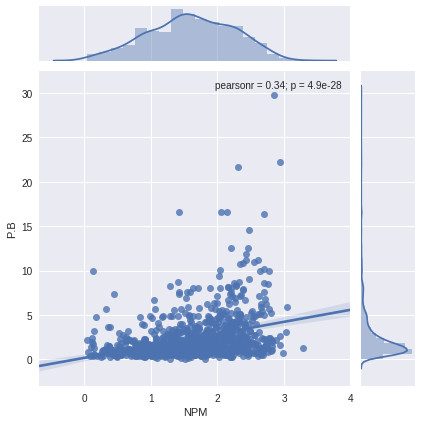

In [192]:
g = sns.jointplot(x = df['NPM'], y = df['P.B'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



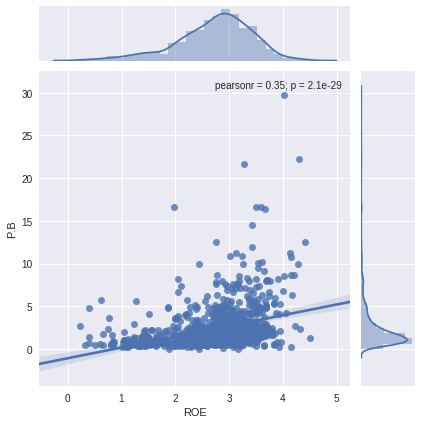

In [193]:
g = sns.jointplot(x = df['ROE'], y = df['P.B'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



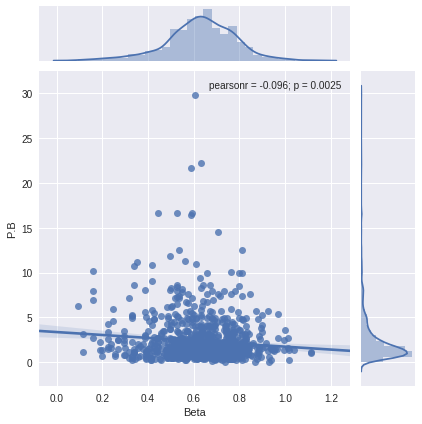

In [194]:
g = sns.jointplot(x = df['Beta'], y = df['P.B'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



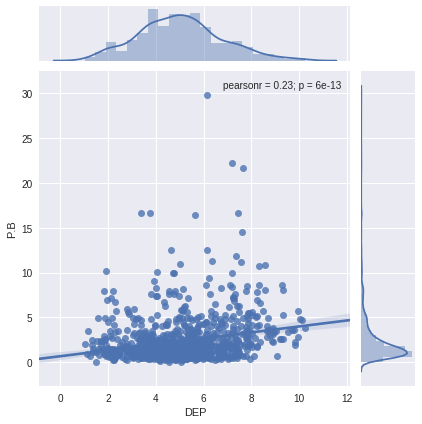

In [195]:
g = sns.jointplot(x = df['DEP'], y = df['P.B'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



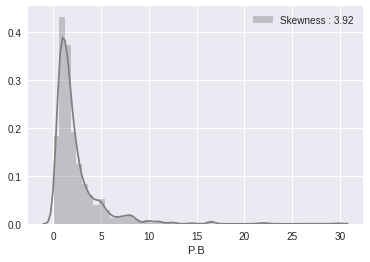

In [197]:
g = sns.distplot(df['P.B'],color="gray")
g = g.legend(['Skewness : {:.2f}'.format(df['P.B'].skew())],loc='best')

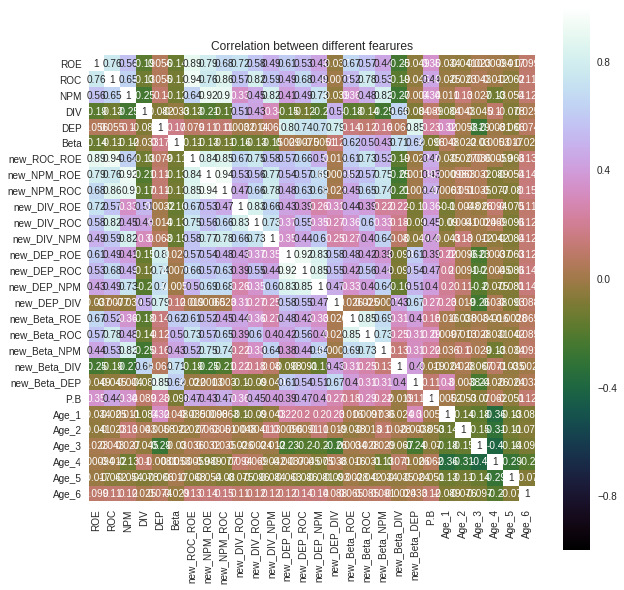

In [198]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')

# Transformation

In [199]:
df['P.B'] = np.log1p(df['P.B'])
Y = df['P.B']
df = df.drop(labels="P.B",axis = 1)

In [200]:
features = df.columns

In [201]:
# Normalize data 
#N = Normalizer()
N = RobustScaler()

N.fit(df)

df = N.transform(df)

In [202]:
train_len = len(df)

In [203]:
## Separate train dataset 
X_train = df[:train_len]

In [204]:
###### Train classifiers
Y_train = Y[:train_len]

In [205]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

# 6.1.1 Cross validate models

In [206]:
# Regression linear models (Lasso, Ridge, Elasticnet)
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [207]:
RMSE(lassocv, X_train, Y_train)

0.42536037187857645

In [208]:
RMSE(ridge, X_train, Y_train)

0.43266196390257211

In [209]:
RMSE(lassolarscv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=1.910e-03, previous alpha=1.592e-05, with an active set of 25 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=4.308e-03, previous alpha=4.052e-05, with an active set of 23 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.473e-04, previous alpha=4.664e-05, with an active set of 19 regressors.

/home/py/anaconda3/lib/python3.6/s

0.42920843734129088

In [210]:
RMSE(elasticnetcv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data w

0.42546194623427225

In [211]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=2.969e-03, previous alpha=3.686e-06, with an active set of 25 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=8.421e-04, previous alpha=2.322e-05, with an active set of 21 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=7.432e-05, previous alpha=6.956e-05, with an active set of 18 regressors.

/home/py/anaconda3/lib/python3.6/s

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

# Features coefficients

In [212]:
print("LassoCV regression has conserved %d features over %d"%(len(features[lassocv.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))
print("LassoLarsCV regression has conserved %d features over %d"%(len(features[lassolarscv.coef_!=0]) ,X_train.shape[1]))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[elasticnetcv.coef_!=0]),X_train.shape[1]))

LassoCV regression has conserved 10 features over 27
Ridge regression has conserved 27 features over 27
LassoLarsCV regression has conserved 9 features over 27
ElasticNetCV regression has conserved 10 features over 27


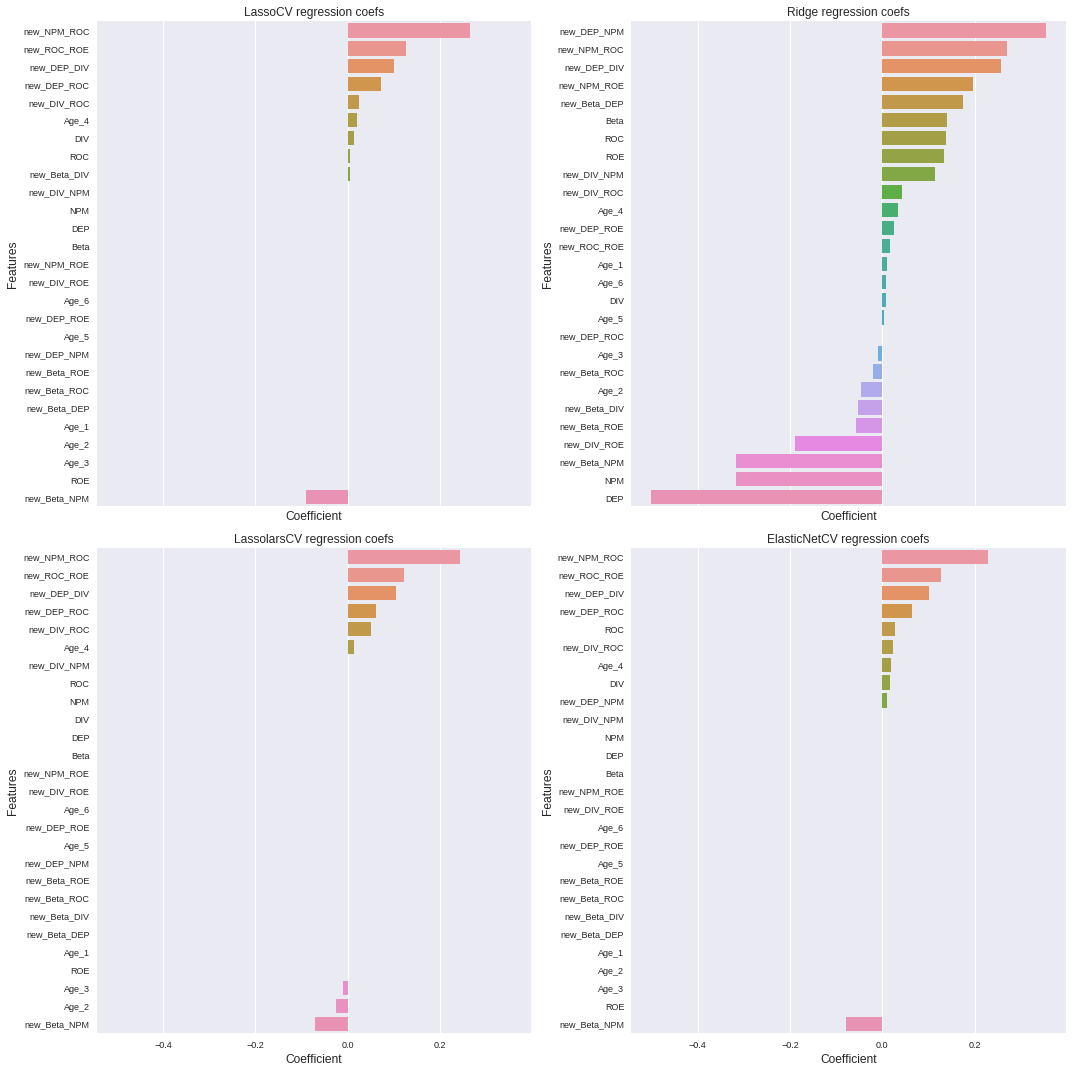

In [213]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("LassoCV", lassocv),("Ridge",ridge),("LassolarsCV",lassolarscv),("ElasticNetCV",elasticnetcv)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.coef_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.coef_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Coefficient",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " regression coefs")
        nregressors += 1
plt.tight_layout()
plt.show()
plt.gcf().clear()

In [214]:
Y_pred_lassocv = np.expm1(lassocv.predict(X_train))
Y_pred_lassolarscv = np.expm1(lassolarscv.predict(X_train))
Y_pred_elasticnetcv = np.expm1(elasticnetcv.predict(X_train))

# Tree based modeling

In [215]:
# XGBoost

#model_xgb = xgb.XGBRegressor(n_estimators=3000, max_depth=2, learning_rate=0.1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)

RMSE(model_xgb,X_train,Y_train)

0.45689723492451861

In [216]:
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = np.expm1(model_xgb.predict(X_train))

In [217]:
# Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
RMSE(GBoost,X_train,Y_train)

0.45001712798938154

In [218]:
GBoost.fit(X_train,Y_train)
Y_pred_GBoost = np.expm1(GBoost.predict(X_train))

In [256]:
# Light GBM
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

RMSE(LightGB,X_train,Y_train)

0.51566382244804887

In [257]:
LightGB.fit(X_train,Y_train)
Y_pred_LightGB = np.expm1(LightGB.predict(X_train))

# Features importance

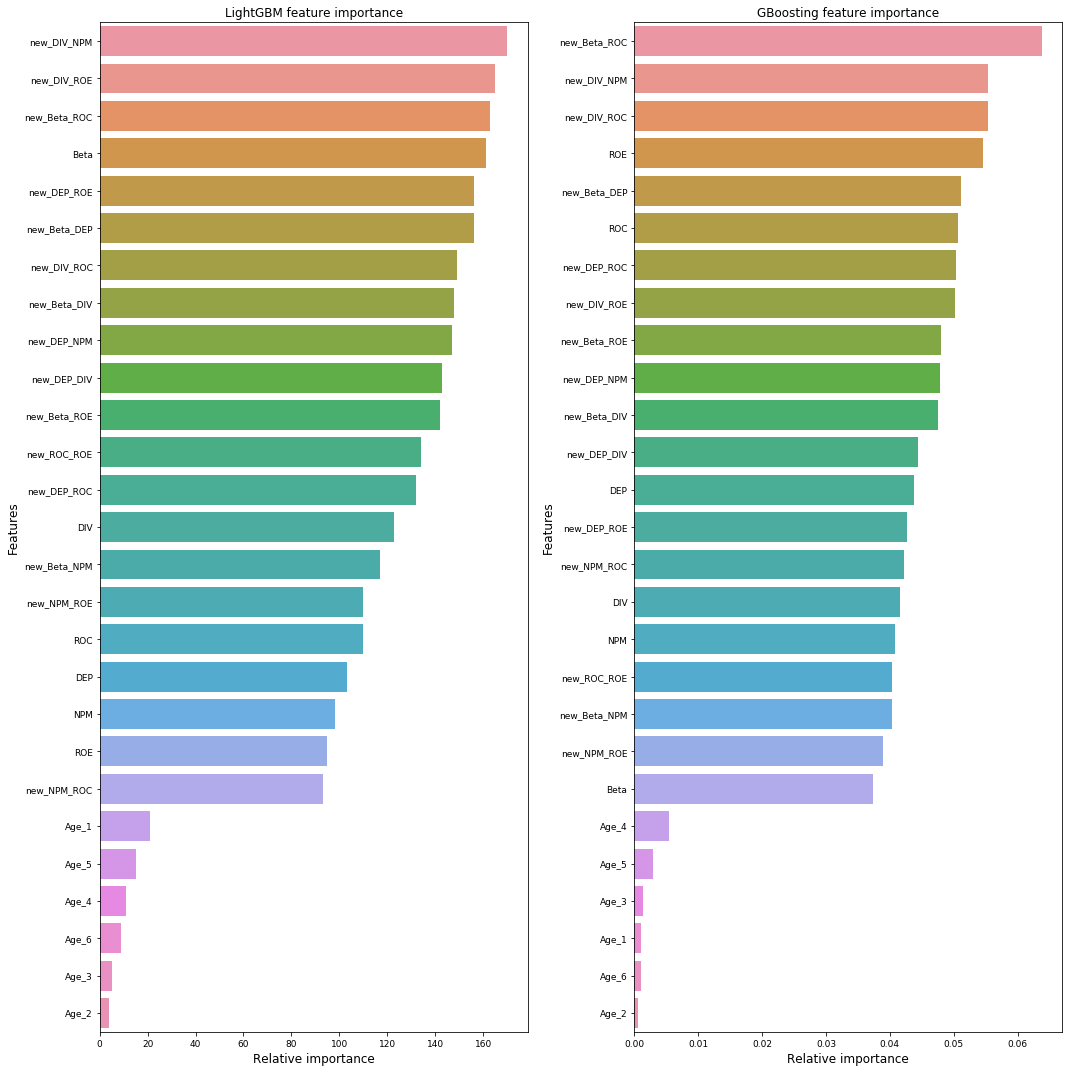

In [258]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,15))

names_regressors = [("LightGBM",LightGB),("GBoosting",GBoost)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.feature_importances_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.feature_importances_[indices][:40] , orient='h',ax=axes[nregressors])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nregressors += 1

plt.tight_layout()
plt.show()
plt.gcf().clear()

# Learning Rate

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data w

IndexError: list index out of range

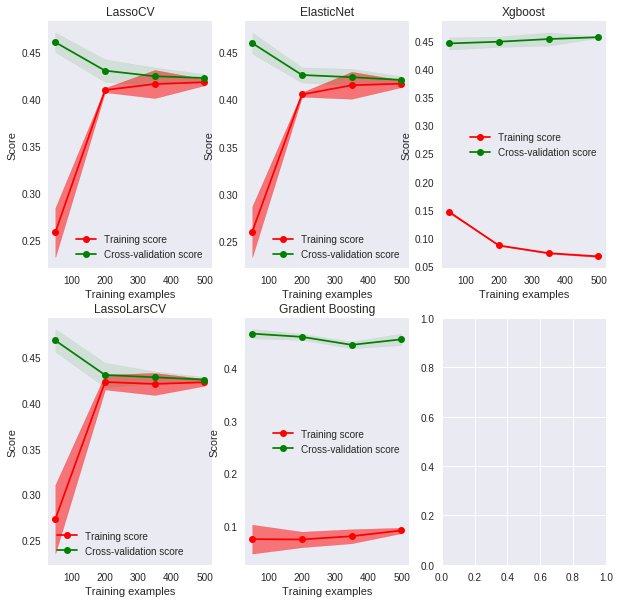

In [219]:
def plot_learning_curves(estimators, titles, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 4)):
    """Generate a simple plot of the test and training learning curve"""
    nrows = len(estimators)//2
    ncols = (len(estimators)//nrows)+ (0 if len(estimators) % nrows == 0 else 1)
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    n = 0
    for col in range(ncols):
        for row in range(nrows):
            estimator = estimators[n]
            title = titles[n]
            axes[row,col].set_title(title)
            
            if ylim is not None:
                axes[row,col].set_ylim(*ylim)
            
            axes[row,col].set_xlabel("Training examples")
            axes[row,col].set_ylabel("Score")
            
            train_sizes, train_scores, test_scores = learning_curve(estimator,
                    X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                    scoring="neg_mean_squared_error")
    
            train_scores = np.sqrt(-train_scores)
            test_scores = np.sqrt(-test_scores)
    
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row,col].grid()
        
            axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.5,
                     color="r")
            axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
            axes[row,col].legend(loc="best")
            
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

    

estimators = [lassocv,lassolarscv,elasticnetcv,GBoost,model_xgb]
titles = ["LassoCV","LassoLarsCV","ElasticNet","Gradient Boosting","Xgboost"]

plot_learning_curves(estimators, titles, X_train, Y_train, cv=2 ,n_jobs=4)